<a href="https://colab.research.google.com/github/icapucap/SE_project/blob/main/vgg_cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import glorot_normal
from keras.utils import np_utils
from keras import backend as K
from keras.datasets import cifar10
from keras.callbacks import  EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import wandb
from wandb.keras import WandbCallback
wandb.init(project="vgg-cifar10")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········
Problem at: <ipython-input-3-e28c2641a0ef> 22 <module>


UsageError: ignored

In [ ]:
batch_size = 128
epochs = 25
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train  /= 255
x_test /= 255

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
               
datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False,  
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,  
            zca_whitening=False,  
            rotation_range=15,  
            width_shift_range=0.1,  
            height_shift_range=0.1,  
            horizontal_flip=True, 
            vertical_flip=False)  
      
datagen.fit(x_train)


In [ ]:
BATCH_NORM = True
num_classes=10

def base_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:], name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(4096))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, name='fc2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('softmax'))

    sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
    return model


cnn_n = base_model()
cnn_n.summary()

cnn_n.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),callbacks=[WandbCallback(data_type="image", validation_data=(x_test, y_test), labels=class_names),
                               EarlyStopping(patience=10, restore_best_weights=True)],verbose=2)
#cnn_n.save_weights('cifar10vgg.h5')




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_38 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_38 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_39 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_39 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)       

TypeError: ignored

313/313 - 3s
0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[  0   2 122   0   0 508   0   0   0 368]
 [  0   2 102   0   0 207   0   0   0 689]
 [  0   3  69   0   0 419   0   0   0 509]
 [  0  14  64   0   0 310   0   0   0 612]
 [  0   5  64   0   0 467   0   0   0 464]
 [  0  15  41   0   0 284   0   0   0 660]
 [  0   5  56   0   0 327   0   0   0 612]
 [  0   5  65   0   0 236   0   0   0 694]
 [  0   6 135   0   0 438   0   0   0 421]
 [  0   4  86   0   0 228   0   0   0 682]]


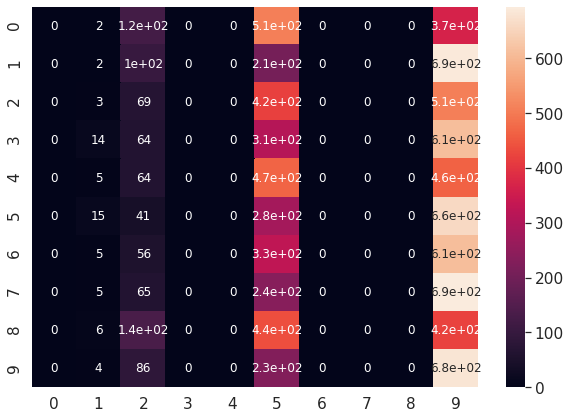

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()